# Time Series Analysis

**Authors:** 
- Marc Villalonga Llobera
- Patxi Juaristi Pagegi

**Date:** 08/01/2024

---

This Jupyter Notebook covers the fourth task of the project for the Data Mining subject of the Laurea Magistrale of the University of Pisa, focused in time series analysis.

## Environment preparation and data reading

First of all, we will install all the required packages, and then import the libraries that we will use:


In [452]:
%%capture
!python -m pip install --upgrade pip
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install scikit-learn
!pip install tslearn
!pip install kneed
!pip install stumpy

In [453]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import stumpy

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

After importing the required libraries, we will read the dataset that we have exported in the task 3, which will contain the data filtered after the data preparation tasks and the score (`city_severity_index`) and people killed (`people_killed`) values that will be used for the analysis.

In [454]:
# Load the dataset
incidents_dataset = pd.read_csv('../project_datasets/incidents_v3.csv', low_memory=False)

## Time Series Analysis

For the analysis, we will only use the incidents occurred in 2014, 2015, 2016 and 2017. So first of all, since we have removed the `date` column in task 3 and we are left with only the `year`, `month` and `day` column split, we reconstruct it based on them.

In [455]:
# Create the column date make the time series easier
incidents_dataset['date'] = pd.to_datetime(incidents_dataset[['year', 'month', 'day']], format='%Y%m%d')

Next, we filter the dataset by those incidents that happened between 2014 and 2017.

In [456]:
# Filter incidents for the years 2014 to 2017
incidents_dataset = incidents_dataset[(incidents_dataset['year'] >= 2014) & (incidents_dataset['year'] <= 2017)]

Then, to extract a time line based on the weeks of every year we have to reconvert the date and use a specific column, named `week`. Using the `%Y-%U` formatting, we get the year and the number of week of each year. For example, *2014-01*, *2014-32*, *2015-7*, *2016-42* and so on.

Following, we group all the incidents that occurred in the same city and the same week.

We calculate the total number of weeks with incidents at each location. Then, we also calculated the total number of weeks in the 4 years together (`total_weeks`). Comparing both values, those cities that do not reach a minimum number of weeks with incidents will be filtered out. In this case, the cities that do not have a number of weeks with incidents higher than 15% of the total number of weeks will be eliminated from the analysis in order to analyze only the most relevant cities (`valid_cities`).

In [457]:
# Add a new column 'week'
incidents_dataset['week'] = incidents_dataset['date'].dt.strftime('%Y-%U')

# Group by city and week, then calculate the total number of weeks with incidents
city_week_counts = incidents_dataset.groupby(['city_or_county', 'week']).size().reset_index(name='week_count')

# Calculate the total number of weeks for the 4 years
total_weeks = len(pd.date_range(start='2014-01-01', end='2017-12-31', freq='W'))

# Filter cities with a number of weeks with incidents greater than 15% of the total weeks
valid_cities = city_week_counts.groupby('city_or_county')['week_count'].sum() > 0.15 * total_weeks
valid_cities = valid_cities[valid_cities].index.tolist()

# Filter data for valid cities
incidents_dataset = incidents_dataset[incidents_dataset['city_or_county'].isin(valid_cities)]

To extract the score, as we have already calculated it, we simply average the score of all the incidents that coincide with the same week and city.

Following, for further visualizations, we sort the dataframe by the `week` column, which is like sorting by date of occurrence.

In [458]:
# Group by city and week, then calculate the average severity index for each week
city_scores = incidents_dataset.groupby(['city_or_county', 'week'])['city_severity_index'].mean().reset_index()

# Order Dataframe by week
city_scores = city_scores.sort_values(by='week')

print(city_scores.head())
city_scores.to_csv('../project_datasets/time_series_data.csv', index=False)

      city_or_county     week  city_severity_index
17523        Holyoke  2014-00             0.000000
19176    Jersey City  2014-00             0.002268
31817        Phoenix  2014-00             0.002212
5231           Bronx  2014-00             0.001484
9846       Covington  2014-00             0.010989


Afterwards, we pivot the `city_scores` dataframe to transform it into a time series format with cities as rows, weeks as columns, and `city_severity_index` values as entries. Then, we fill missing values (weeks without incidents) with 0.

In [459]:
# Pivot the data to get city-wise time series
time_series_data = city_scores.pivot(index='city_or_county', columns='week', values='city_severity_index')

# Fill missing values (weeks without incidents) with 0 or any other value
time_series_data = time_series_data.fillna(0)

Next, to see an example of the time series data by city, we will select Detroit and Oakland, two of the most dangerous cities in the USA to see the evolution of the severity score over the time. Both of the cities have a similar evolution.

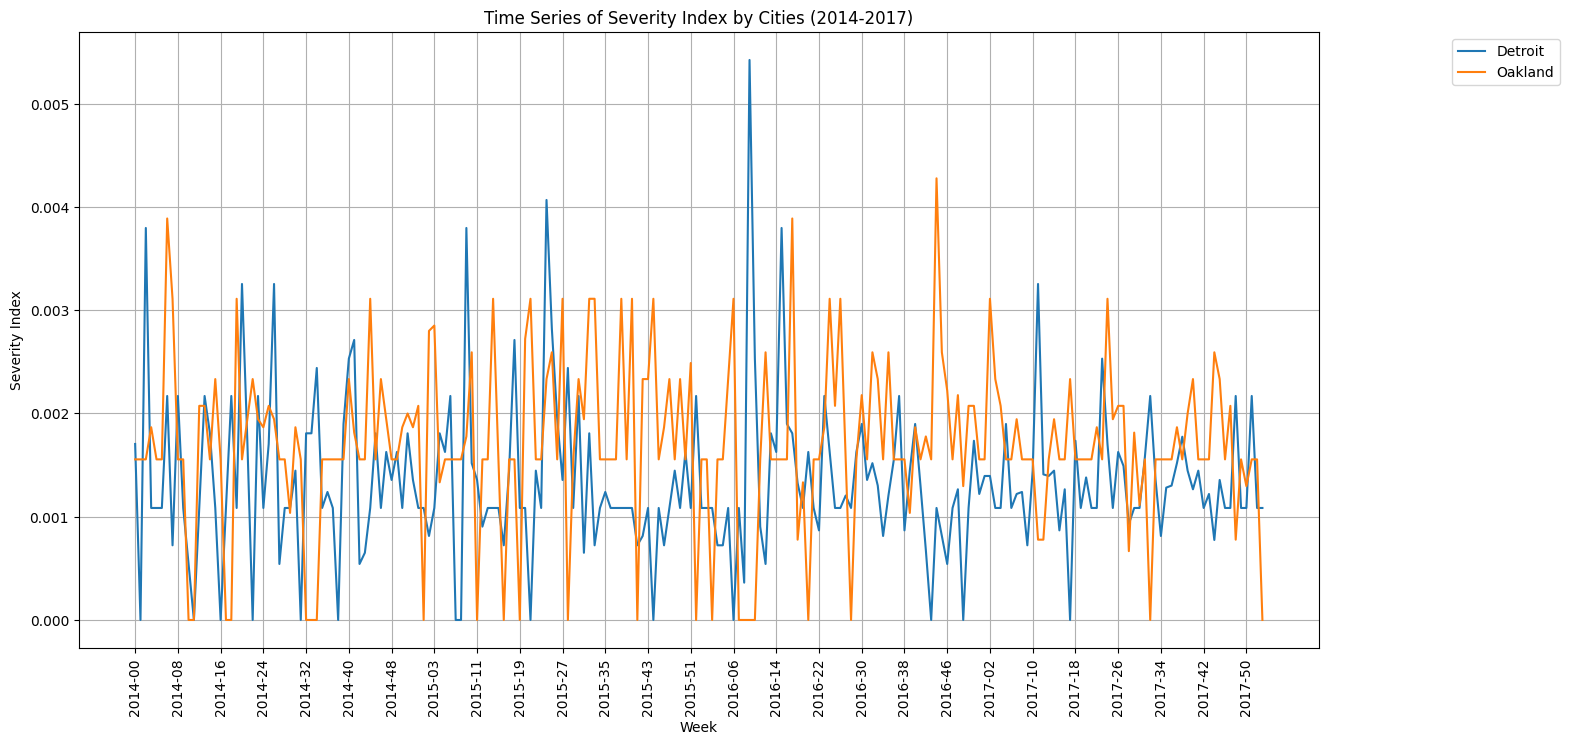

In [460]:
# Specify the cities you want to include in the plot
cities_of_interest = ['Detroit', 'Oakland']

# Plotting the time series for selected cities
plt.figure(figsize=(16, 8))
for city in cities_of_interest:
    plt.plot(time_series_data.columns, time_series_data.loc[city], label=city)

# Set x-axis ticks to display one value per 8 weeks
ticks = time_series_data.columns[::8]
plt.xticks(ticks, ticks, rotation=90)
plt.title('Time Series of Severity Index by Cities (2014-2017)')
plt.xlabel('Week')
plt.ylabel('Severity Index')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

### Clustering and motif/anomalies extraction

After creating the time series of the cities and their severity index, we apply clustering techniques to uncover patterns and similarities among cities. Additionally, we delve into motif and anomaly extraction, providing insights into recurring patterns and exceptional occurrences in the severity index data.

#### Clustering

Before making the definitive clustering, as we did in the task 2 of clustering analysis, we perform a comparison to determine the optimal number of clusters (k) for clustering cities based on their normalized severity index time series data. To achieve this, we use the K-means clustering algorithm, iterating over a range of potential cluster numbers. We evaluate each configuration by calculating both the inertia, a measure of compactness within clusters, and the silhouette score, a metric assessing the quality of clustering. The silhouette score reflects how well-separated the clusters are, with higher values indicating better-defined clusters. The code employs the elbow method, visually represented in a plot, to identify the optimal k value based on the point where additional clusters cease to significantly reduce inertia.

Observing the results, we can see that the best Silhouette score is obtained with 8 clusters. However, we did not obtain the best inertia value. This happens because `KneeLocator` might not always provide a clear elbow point, so relying on the silhouette score along with visual inspection of the inertia curve can help in choosing an appropriate value for k. In this case the silhouette score suggests a good value and the inertia curve is relatively flat, so k=8 may be a reasonable choice.

Clusters: 2, Silhouette Score: 0.1582635049720914, Inertia: 116109.63197714543
Clusters: 3, Silhouette Score: 0.13206830824547938, Inertia: 115252.8881559347
Clusters: 4, Silhouette Score: 0.14537801651743892, Inertia: 114403.61069692925
Clusters: 5, Silhouette Score: 0.11014360050837252, Inertia: 113656.69238609889
Clusters: 6, Silhouette Score: 0.13961465324505037, Inertia: 113072.25170375369
Clusters: 7, Silhouette Score: 0.08189120646369284, Inertia: 112597.96320899733
Clusters: 8, Silhouette Score: 0.18441013956797575, Inertia: 111329.55760584457
Clusters: 9, Silhouette Score: 0.06839858056124364, Inertia: 110668.67371754629

Optimal k value using inertia: None
Optimal k value using silhouette Score: 8


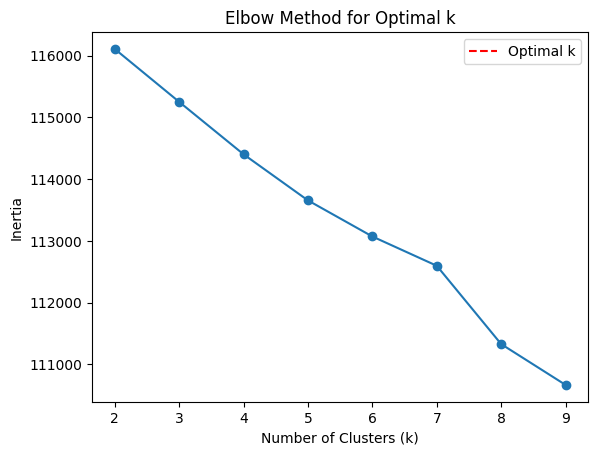

In [461]:
# Normalize the time series data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(time_series_data)

# Specify a range of cluster numbers to try
cluster_range = range(2, 10)

# Determine the optimal number of clusters (k) using the elbow method
best_sc_score = -1
optimal_k_sc = 2
inertia = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
    clusters = kmeans.fit_predict(normalized_data)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(normalized_data, clusters)
    print(f'Clusters: {k}, Silhouette Score: {silhouette_avg}, Inertia: {kmeans.inertia_}')
    
    # Update best results
    if silhouette_avg > best_sc_score:
        best_sc_score = silhouette_avg
        optimal_k_sc = k

# Find the optimal k using the KneeLocator from kneed library
knee = KneeLocator(cluster_range, inertia, curve="convex", direction="decreasing")
optimal_k_inertia = knee.elbow

# Print the optimal k
print(f"\nOptimal k value using inertia: {optimal_k_inertia}")
print(f"Optimal k value using silhouette Score: {optimal_k_sc}")

# Plot the elbow method with the optimal k
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.vlines(optimal_k_inertia, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Optimal k')
plt.legend()
plt.show()


With the best k value obtained, we perform the clustering and create a merged dataframe with the city names and corresponding cluster assignments.

In [462]:
best_k = 8

# Apply K-means clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=100)
clusters = kmeans.fit_predict(normalized_data)

# Create a DataFrame with the city names and corresponding cluster assignments
cluster_df = pd.DataFrame({'city_or_county': city_scores['city_or_county'].unique(), 'cluster': clusters})

# Merge the original DataFrame with the clustering results
city_scores = pd.merge(city_scores, cluster_df, on='city_or_county', how='left')

# Visualize the clustered cities or perform additional analysis
print(city_scores)

      city_or_county     week  city_severity_index  cluster
0            Holyoke  2014-00             0.000000        4
1        Jersey City  2014-00             0.002268        4
2            Phoenix  2014-00             0.002212        4
3              Bronx  2014-00             0.001484        4
4          Covington  2014-00             0.010989        4
...              ...      ...                  ...      ...
44185        Trenton  2017-53             0.003072        2
44186         Joliet  2017-53             0.012739        4
44187   Jacksonville  2017-53             0.001248        4
44188     Marysville  2017-53             0.000000        1
44189      Ypsilanti  2017-53             0.012048        4

[44190 rows x 4 columns]


Then we plot the results to see the clusters in a visual way. However, displaying all the clusters together, the difference is not very clear.

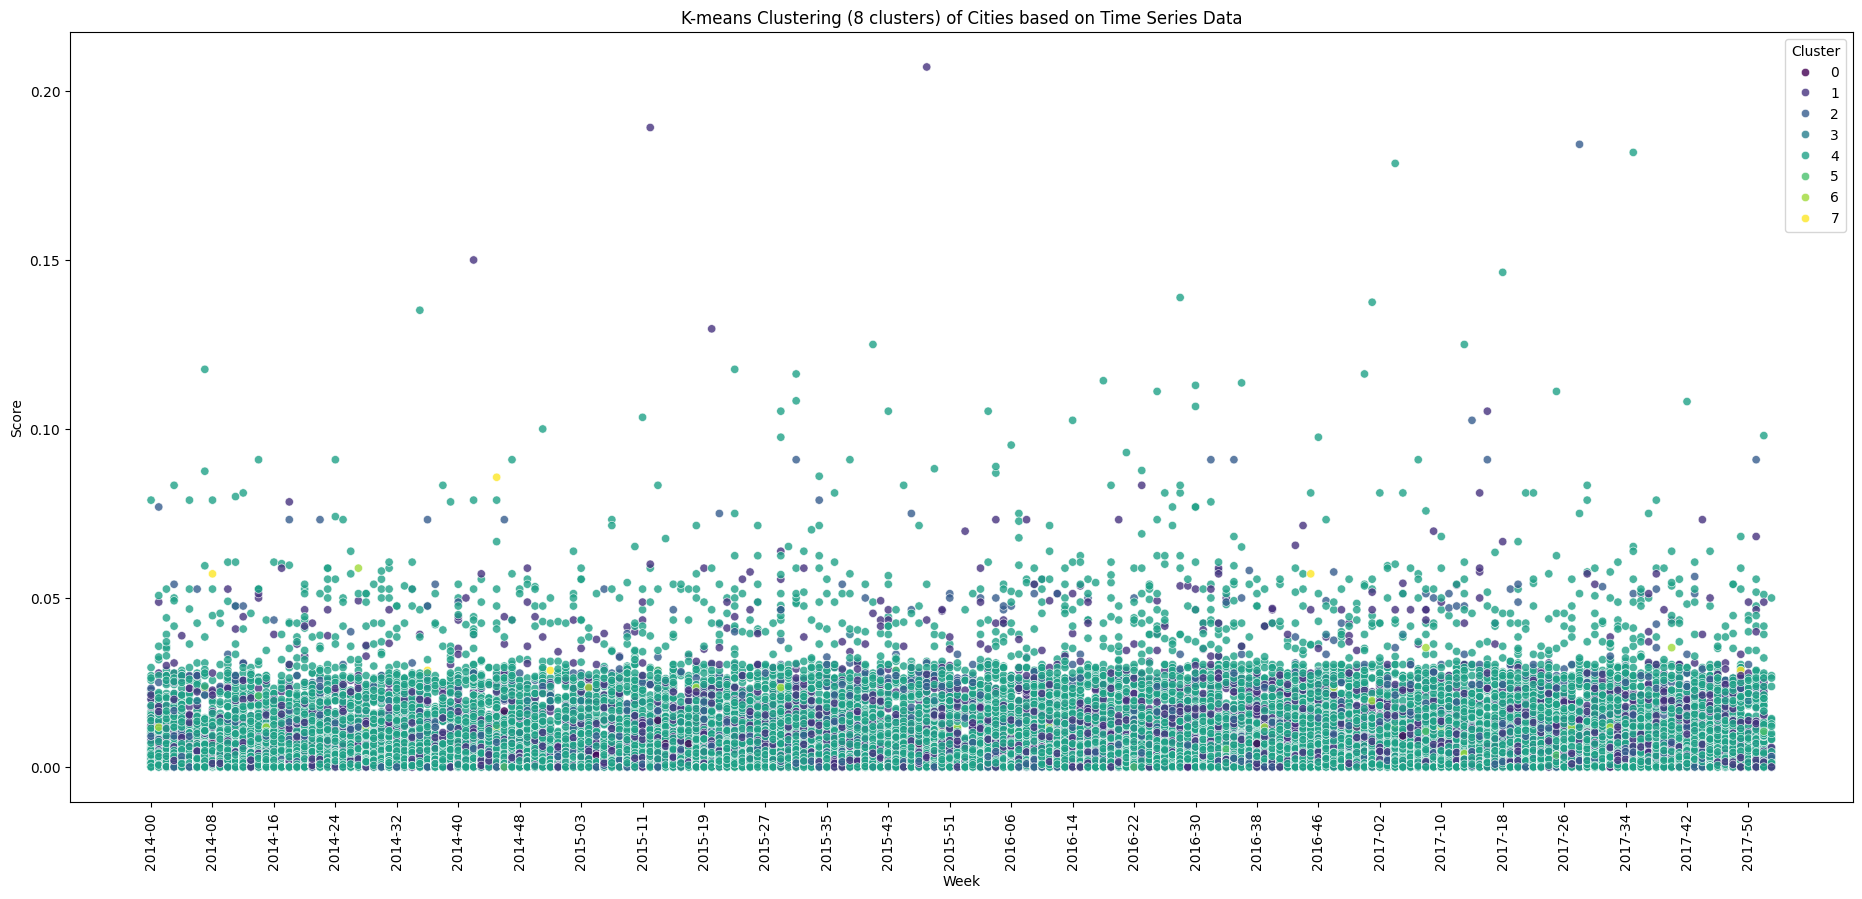

In [463]:
# Set x-axis ticks to display one value per 8 weeks
ticks = city_scores['week'].unique()[::8]

# Visualize the clustered cities with improved color palette and transparency
plt.figure(figsize=(23, 10))
sns.scatterplot(x='week', y='city_severity_index', hue='cluster', data=city_scores, palette='viridis', legend='full', alpha=0.8, edgecolor='w')
plt.xlabel('Week')
plt.ylabel('Score')
plt.xticks(ticks, ticks, rotation=90)
plt.title(f'K-means Clustering ({best_k} clusters) of Cities based on Time Series Data')
plt.legend(title='Cluster')
plt.show()

So to see the clusters in a clearer way, we display them separately. There are 3 of them with lot of data, mostly with high scores, while the other 5 have less data with less average score or two defined patters of average date. Due to the constant average score we can say that cluster 1, 6 and 7 are grouped mostly because of the scoring, while cluster 4 and cluster 8 are probably grouped by a mix of score and week.

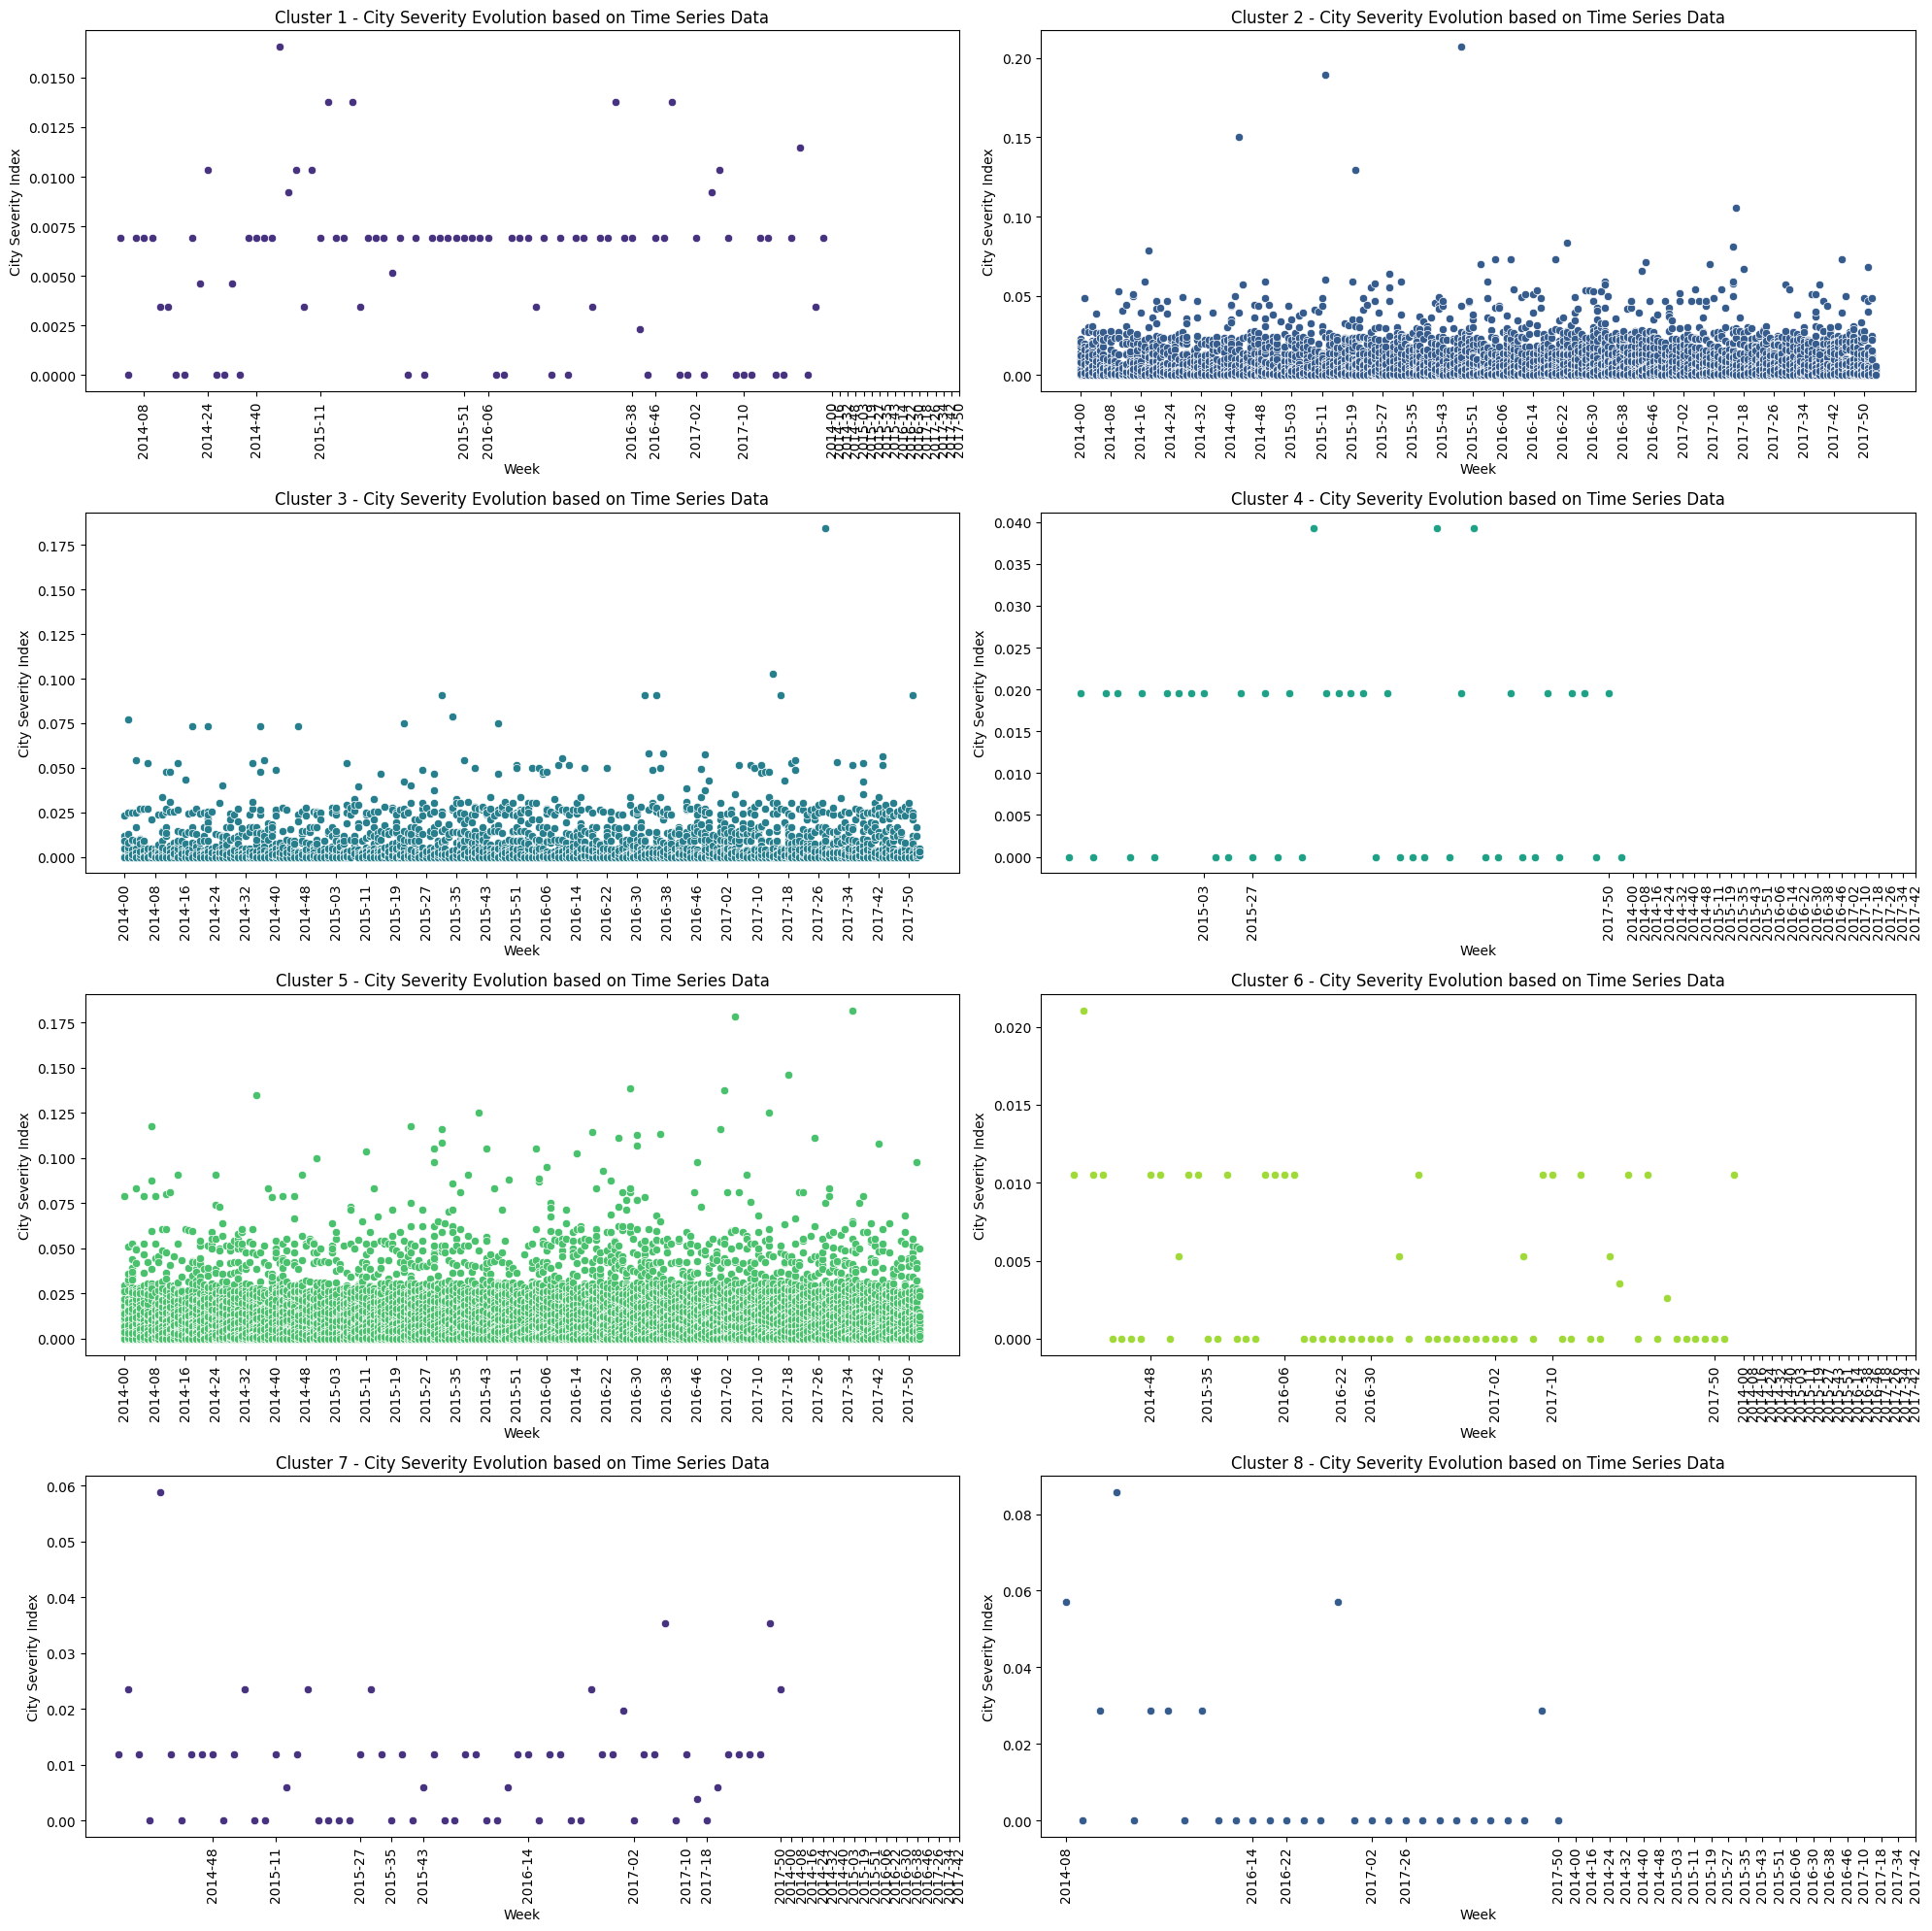

In [464]:
# Set the number of rows and columns for the subplot grid
num_rows = 4
num_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Visualize each cluster separately
for cluster_num in range(best_k):
    # Filter the DataFrame for the current cluster
    cluster_data = city_scores[city_scores['cluster'] == cluster_num]

    # Use modulo to repeat colors if there are more clusters than colors in the palette
    color = sns.color_palette("viridis")[cluster_num % len(sns.color_palette("viridis"))]

    # Plot the scatter plot on the current subplot
    sns.scatterplot(x='week', y='city_severity_index', data=cluster_data, color=color, edgecolor='w', ax=axes[cluster_num])
    
    axes[cluster_num].set_xticks(ticks)
    axes[cluster_num].set_xticklabels(ticks, rotation=90)    
    axes[cluster_num].set_xlabel('Week')
    axes[cluster_num].set_ylabel('City Severity Index')
    axes[cluster_num].set_title(f'Cluster {cluster_num + 1} - City Severity Evolution based on Time Series Data')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


#### Motif and Anomalies

We have seen before that there is nothing considerably strange to comment, but to be sure we will extract graphs of the average scores based on the two different parameters that we have, the weeks and the cities, and calculate if there is any motif (repetitive pattern) or any anomaly we haven't seen.

##### Week based

Using the matrix profile technique from the `stumpy` library, we compute profiles and extract motifs—key repetitive features in the time series. Additionally, the Z-score is calculated to identify anomalies by assessing deviations from the mean in terms of standard deviations. Anomalies are determined based on a specified threshold, in this case 2,5.

The results are visualized in a plot, offering a clear representation of motifs (represented in black dots) and anomalies (red dots) within the severity index time series. Moreover, the weeks with anomalies are printed ("2014-41", "2015-23" and "2015-29"), which they have a clearly high or low value compared with the trend, as well as the ones with motifs ("2017-15", "2014-09", "2015-23").

The values with high severity scores may be due to certain American holidays, special days that occur on those dates or some specific event that occurred and triggered the number of participants in the accidents at those times. The motif with low severity value, may be due to some act that reduced, for example, crime and, consequently, the incidents that occurred.

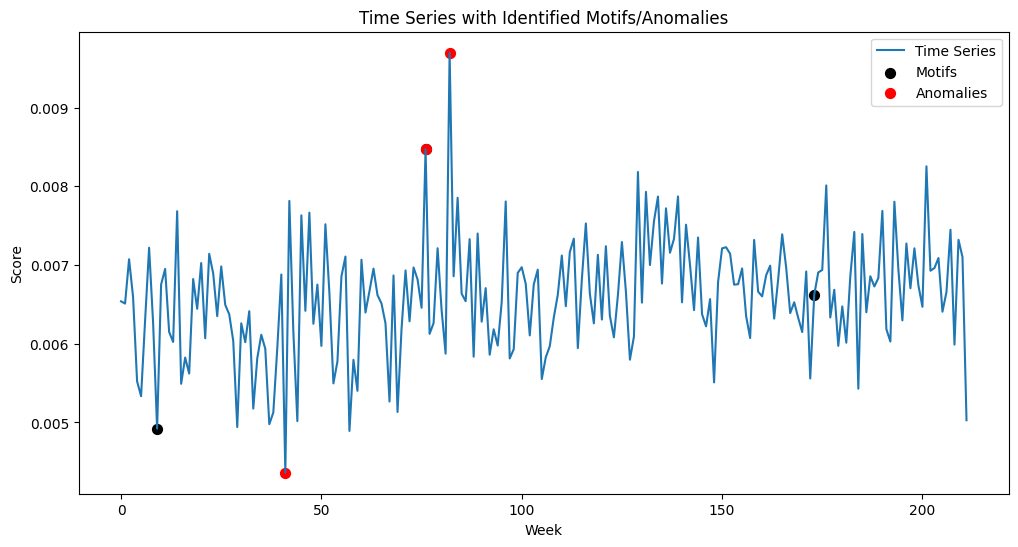

Weeks with anomalies: ['2014-41' '2015-23' '2015-29']
Weeks with motifs: ['2017-15' '2014-09' '2015-23']


In [465]:
# Obtain the time series based on the 'week' column
time_series_data_wb = city_scores.groupby('week')['city_severity_index'].mean().values

# Set the window size for the matrix profile
window_size = 3

# Calculate the matrix profile
profile = stumpy.stump(time_series_data_wb, m=window_size)

# Extract the indices of motifs (starting points of repetitive subsequences)
motif_indices = np.argsort(profile[:, 0])[:window_size]

# Calculate the Z-Score for anomaly detection
z_scores = (time_series_data_wb - np.mean(time_series_data_wb)) / np.std(time_series_data_wb)

# Set a threshold to identify anomalies
anomaly_threshold = 2.5

# Identify the indices of anomalies
anomaly_indices = np.where(np.abs(z_scores) > anomaly_threshold)[0]

# Visualize the time series with identified anomalies
plt.figure(figsize=(12, 6))
plt.plot(time_series_data_wb, label='Time Series')
plt.scatter(motif_indices, time_series_data_wb[motif_indices], color='black', label='Motifs', s=50)
plt.scatter(anomaly_indices, time_series_data_wb[anomaly_indices], color='red', label='Anomalies', s=50)
plt.title('Time Series with Identified Motifs/Anomalies')
plt.xlabel('Week')
plt.ylabel('Score')
plt.legend()
plt.show()

# Print the weeks with anomalies and motifs
anomaly_weeks = city_scores['week'].unique()[anomaly_indices]
print("Weeks with anomalies:", anomaly_weeks)

motif_weeks = city_scores['week'].unique()[motif_indices]
print("Weeks with motifs:", motif_weeks)

It could be a possibility to remove all the rows that have the value of the weeks that have any anomaly or motif in the next way. Nevertheless, we will not use the filtered dataframe.

In [466]:
# Filter out the rows with anomalies
filtered_city_scores = city_scores[~city_scores['week'].isin(np.concatenate([anomaly_weeks, motif_weeks]))]

# Verify the removal

print("Dataframe original size: ", city_scores.shape[0])
print("Dataframe size after anomaly/motif removal: ", filtered_city_scores.shape[0])


Dataframe original size:  44190
Dataframe size after anomaly/motif removal:  43173


##### City based

As we did based on the incident weeks, we perform the same analysis focusing in the cities.

If we look by city rather than by week, we can see that there are three marked anomalies, which clearly have a high severity index value compared to the rest of the cities. This could be an anomaly or simply that these three cities ("Providence", "Baton Rouge" and "Saint Petersburg") are more likely to have higher severity incidents than the average of the rest of the cities.

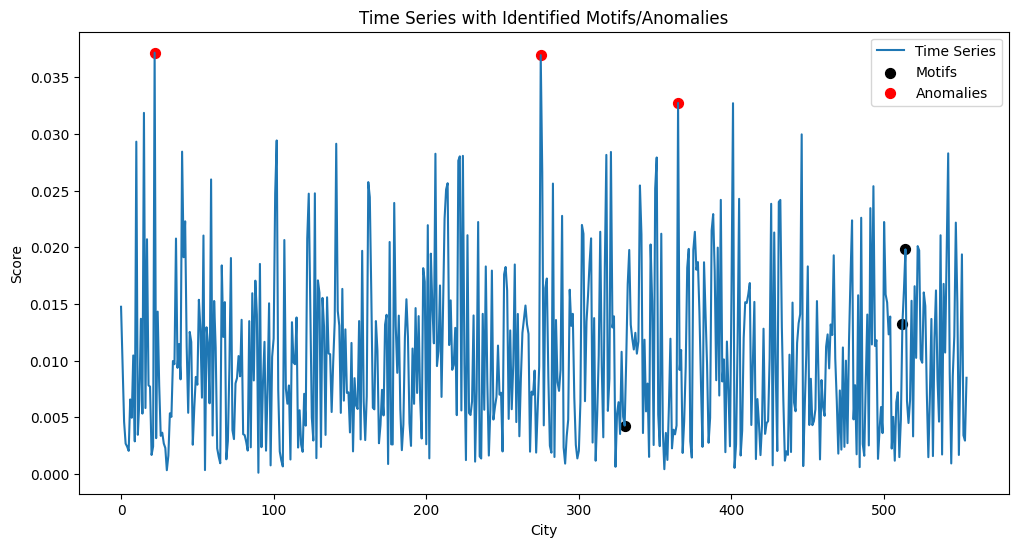

Cities with anomalies: ['Providence' 'Baton Rouge' 'Saint Petersburg']
Cities with motifs: ['Tucson' 'Long Beach' 'Springfield']


In [467]:
# Obtain the time series based on the 'city_or_county' column
time_series_data_cb = city_scores.groupby('city_or_county')['city_severity_index'].mean().values

# Set the window size for the matrix profile
window_size = 3

# Calculate the matrix profile
profile = stumpy.stump(time_series_data_cb, window_size)

# Extract the indices of motifs (starting points of repetitive subsequences)
motif_indices = np.argsort(profile[:, 0])[:window_size]

# Calculate the Z-Score for anomaly detection
z_scores = (time_series_data_cb - np.mean(time_series_data_cb)) / np.std(time_series_data_cb)

# Set a threshold to identify anomalies (adjust as needed)
anomaly_threshold = 3

# Identify the indices of anomalies
anomaly_indices = np.where(np.abs(z_scores) > anomaly_threshold)[0]

# Visualize the time series with identified anomalies
plt.figure(figsize=(12, 6))
plt.plot(time_series_data_cb, label='Time Series')
plt.scatter(motif_indices, time_series_data_cb[motif_indices], color='black', label='Motifs', s=50)
plt.scatter(anomaly_indices, time_series_data_cb[anomaly_indices], color='red', label='Anomalies', s=50)
plt.title('Time Series with Identified Motifs/Anomalies')
plt.xlabel('City')
plt.ylabel('Score')
plt.legend()
plt.show()

# Extract the names of cities where anomalies occur
anomaly_cities = city_scores['city_or_county'].iloc[anomaly_indices].unique()
print("Cities with anomalies:", anomaly_cities)

motif_cities = city_scores['city_or_county'].iloc[motif_indices].unique()
print("Cities with motifs:", motif_cities)

To check for anomalies, we make the graph with the initial time series including the cities with anomalies. This way, we can check if there are possible anomalies, or there are just more dangerous cities than the average.

Observing the graph, we can se see clearly that there is a considerable anomaly in the case of Saint Petersburg, where the value of week 2014-07 is huge compared with the trend.

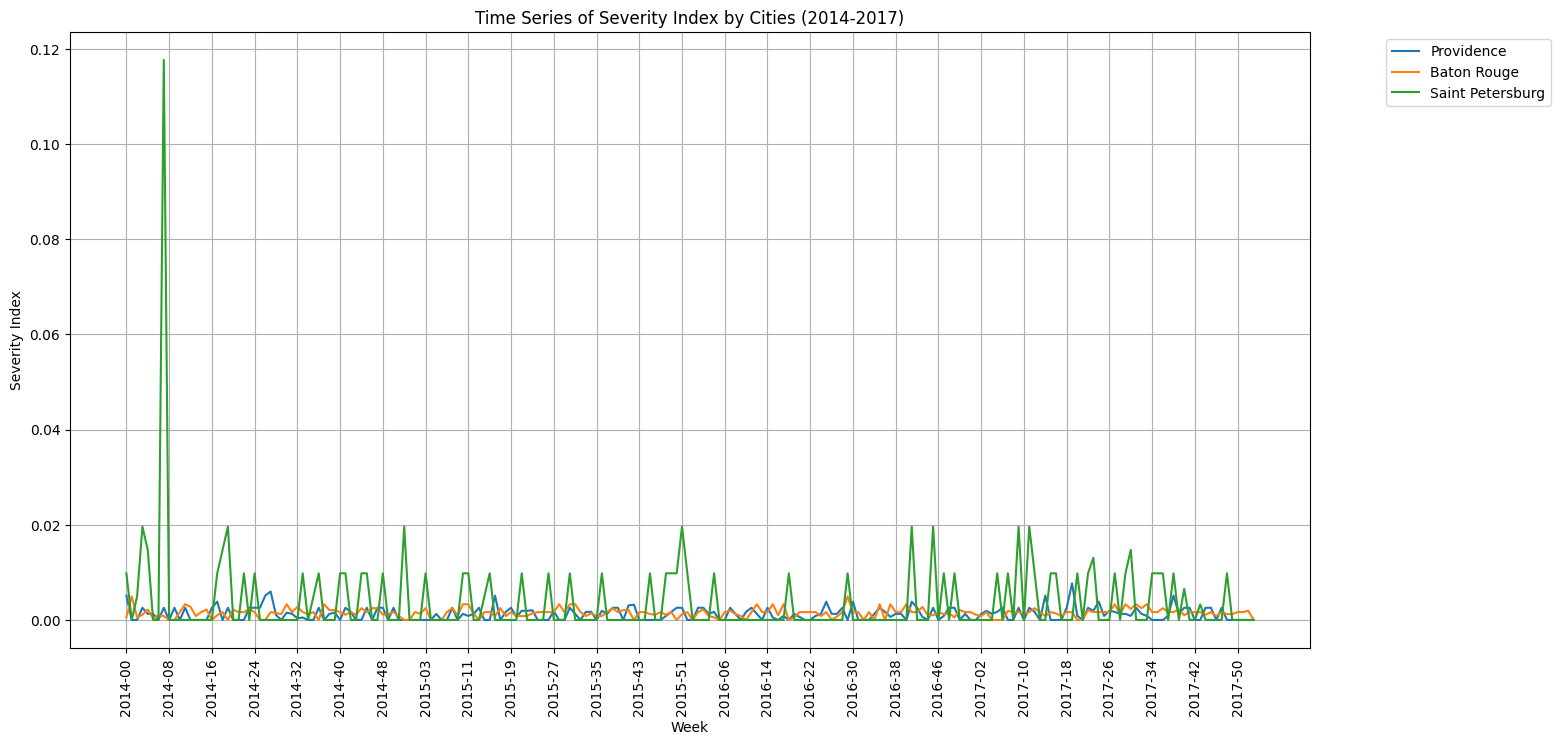

In [468]:
def city_based_anomaly_detection_plot(cities_of_interest):

    # Plotting the time series for selected cities
    plt.figure(figsize=(16, 8))
    for city in cities_of_interest:
        plt.plot(time_series_data.columns, time_series_data.loc[city], label=city)

    # Set x-axis ticks to display one value per 8 weeks
    ticks = time_series_data.columns[::8]
    plt.xticks(ticks, ticks, rotation=90)
    plt.title('Time Series of Severity Index by Cities (2014-2017)')
    plt.xlabel('Week')
    plt.ylabel('Severity Index')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.show()

city_based_anomaly_detection_plot(['Providence', 'Baton Rouge', 'Saint Petersburg'])

To confirm it we execute the following command:

In [469]:
print(city_scores[(city_scores['week'].between('2014-03', '2014-08')) & (city_scores['city_or_county'] == 'Saint Petersburg')])

        city_or_county     week  city_severity_index  cluster
604   Saint Petersburg  2014-03             0.019608        4
707   Saint Petersburg  2014-04             0.014706        4
1196  Saint Petersburg  2014-07             0.117647        4


And we proceed to remove this line:

In [470]:
city_scores = city_scores.drop(city_scores[(city_scores['week'] == '2014-07') & (city_scores['city_or_county'] == 'Saint Petersburg')].index)

And see the updated plot. Analyzing the current result, we can observer that Sain Petersburg has weird values, including anomalies and motifs, because we can detect some pattern as well. So the best will be removing the city from the dataset.

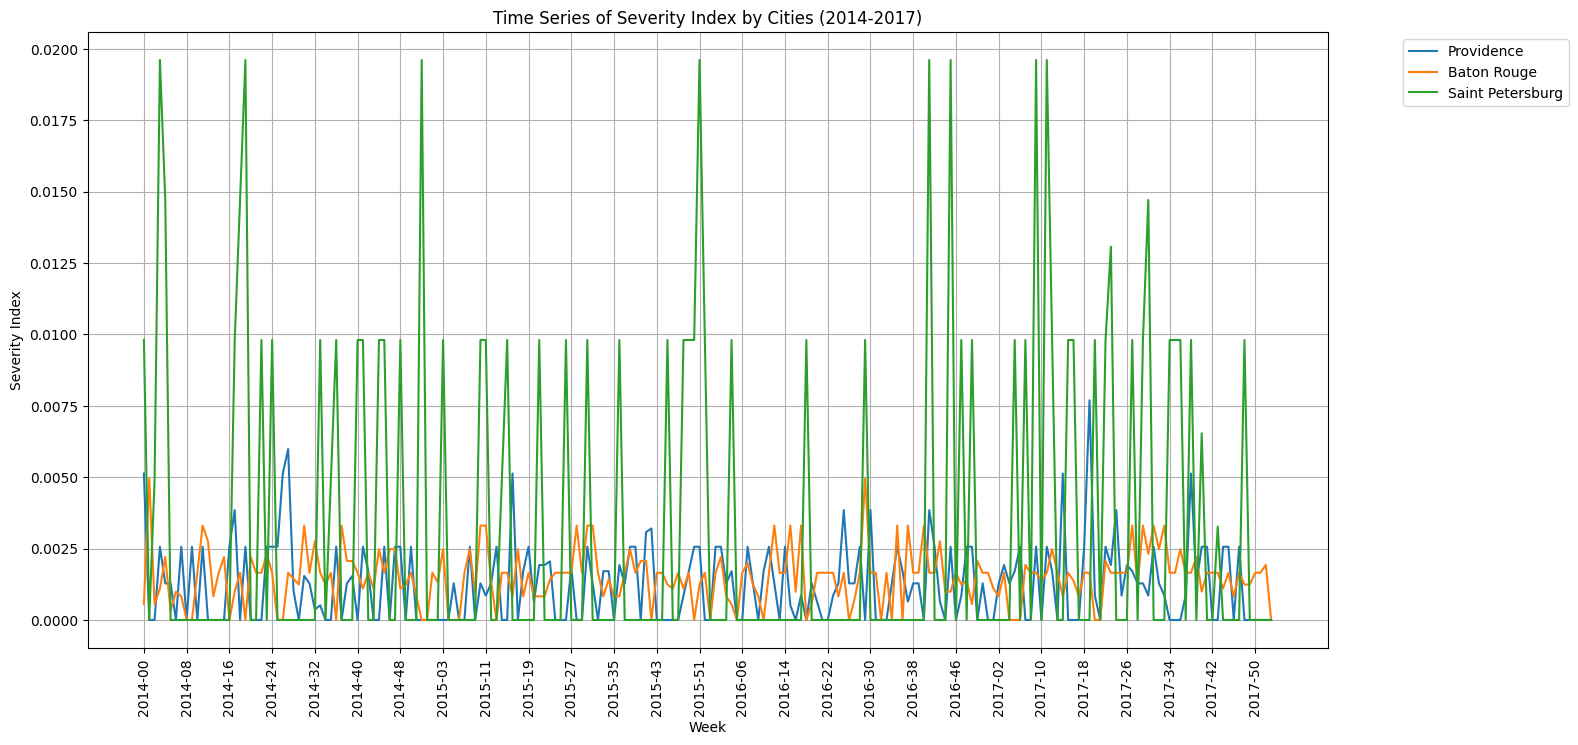

In [471]:
# Update the time series data
time_series_data = city_scores.pivot(index='city_or_county', columns='week', values='city_severity_index')
time_series_data = time_series_data.fillna(0)

# Make the plot
city_based_anomaly_detection_plot(['Providence', 'Baton Rouge', 'Saint Petersburg'])

Then, to conclude, we compare the two cities marked as anomalies with Detroit, which is consiered one of the most dangerous cities in the USA. In the comparison, we can not detect any remarkable difference, maybe the value of Providence that has a bigger `city_severity_index` in the 2017-18 week.

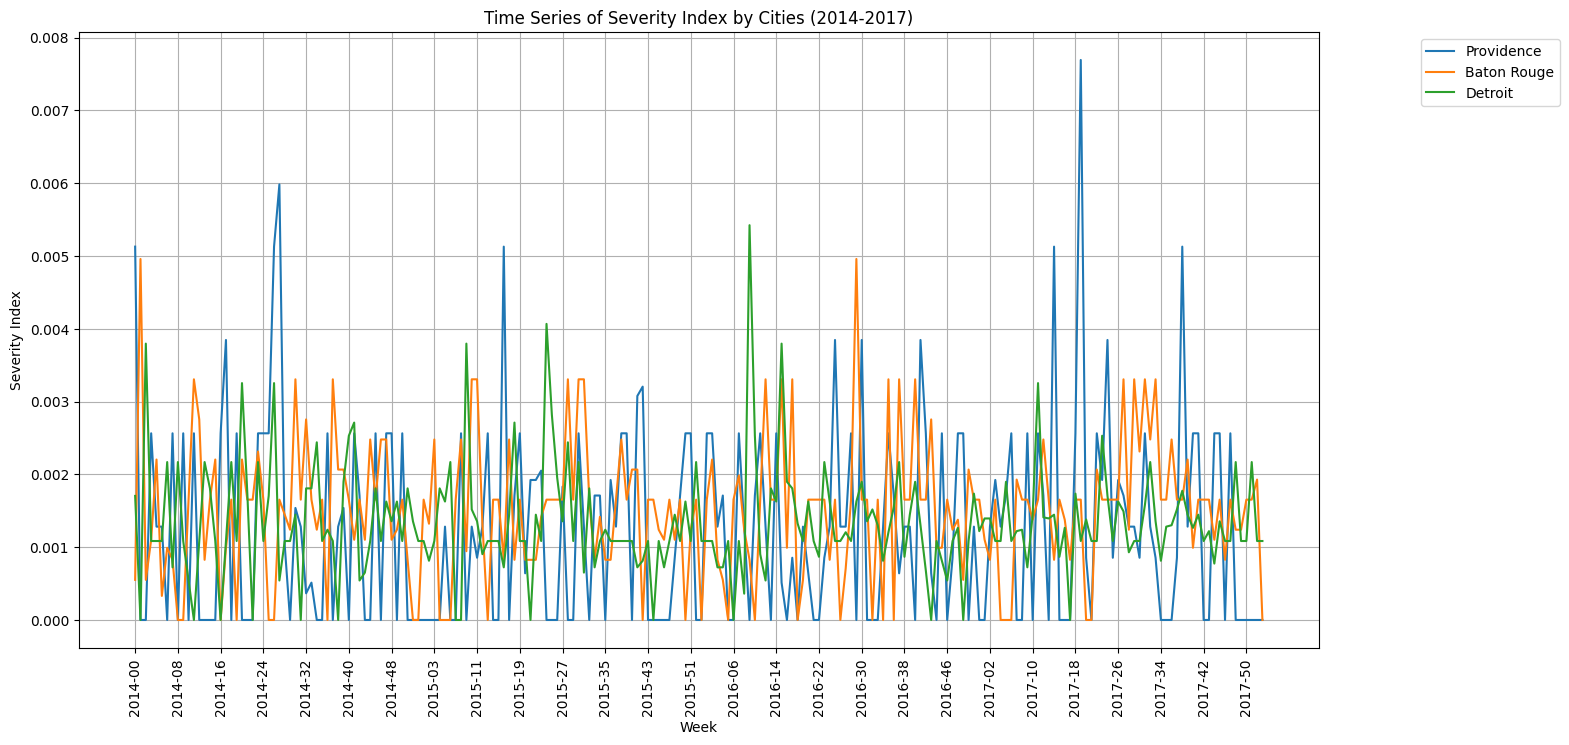

In [472]:
city_scores = city_scores.drop(city_scores[city_scores['city_or_county'] == 'Saint Petersburg'].index)

# Update the time series data
time_series_data = city_scores.pivot(index='city_or_county', columns='week', values='city_severity_index')
time_series_data = time_series_data.fillna(0)

# Make the plot
city_based_anomaly_detection_plot(['Providence', 'Baton Rouge', 'Detroit'])

Then, we will carry out the same process to analyze the cities that were marked as motifs.

Observing the resulting graph, we can affirm that even tough there are some little patterns that they repeat, we can not say that there is a really clear pattern that we should consider. Anyway, we can observe the difference in the severity index between Tucson and Long Beach, compared with the Springfield one.

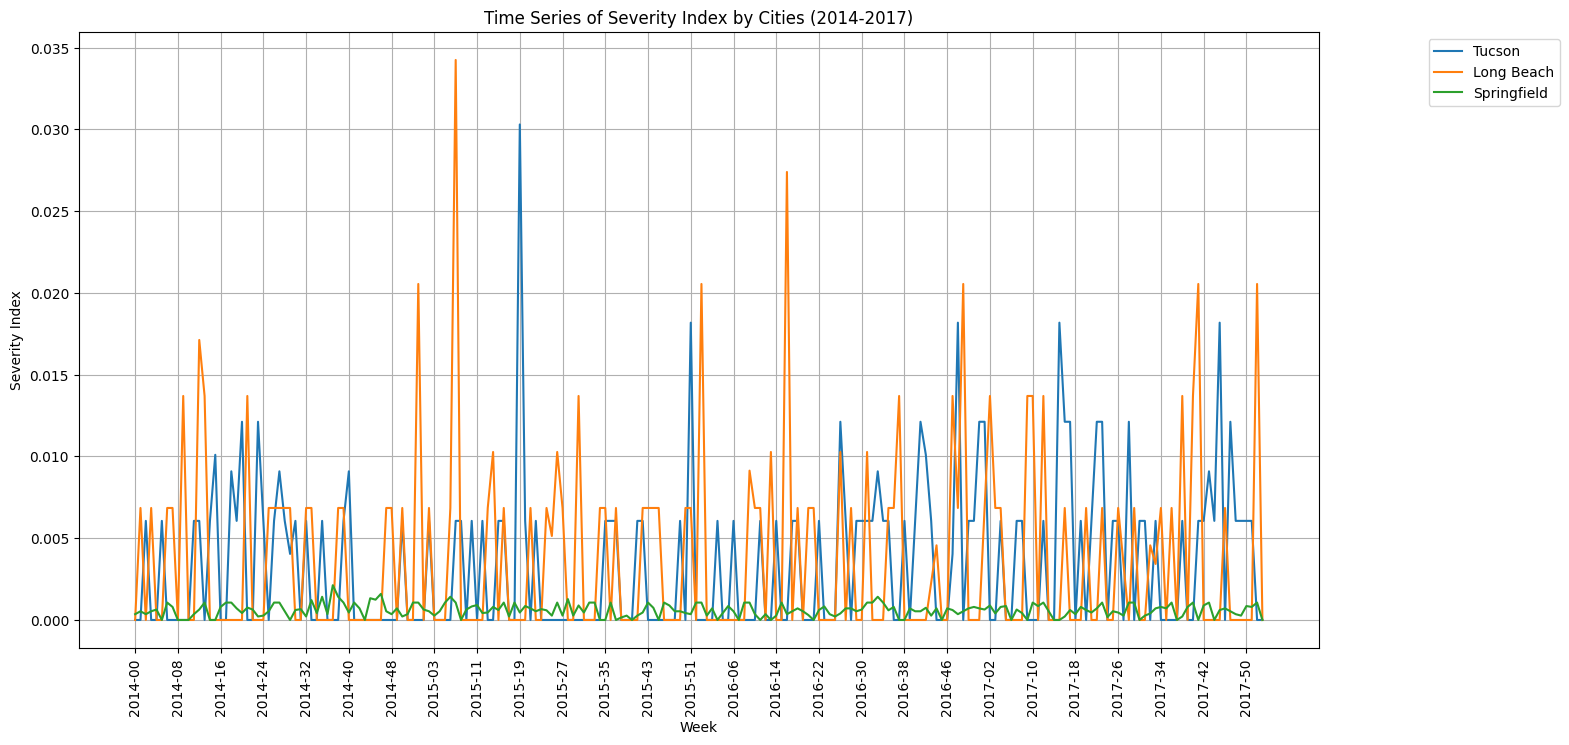

In [473]:
city_based_anomaly_detection_plot(['Tucson', 'Long Beach', 'Springfield'])

### Shapelet extraction

Exploiting the created time series, extract the shapelet according to the class of the
binary variable isKilled.
**Note**: For this subtask there must be no relationship between the score used for the time
series and the n_killed variable, as isKilled is derived from this.

In [26]:
time_series_data = pd.read_csv('../project_datasets/time_series_data.csv', low_memory=False)
incidents_dataset = pd.read_csv('../project_datasets/incidents_v3.csv', low_memory=False)
time_series_data['people_killed'] = incidents_dataset['people_killed']
time_series_data = time_series_data.drop(columns='city_severity_index')
print(time_series_data)

# Import necessary libraries
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_selection import select_features
from tsfresh.utilities.dataframe_functions import impute

# Extract shapelet features
extracted_features = extract_features(time_series_data, column_id="city_or_county", column_sort="week", default_fc_parameters="efficient", n_jobs=1)

# Drop irrelevant features and impute missing values
imputed_features = impute(extracted_features)
features_filtered = select_features(imputed_features, y)

# Print the extracted shapelet features
print("Extracted Shapelet Features:")
print(features_filtered)

         city_or_county     week  people_killed
0             Knoxville  00-2014              0
1            Des Moines  00-2014              1
2      North Charleston  00-2014              0
3            Saint Paul  00-2014              1
4               Detroit  00-2014              1
...                 ...      ...            ...
44185            Topeka  53-2017              0
44186           Norfolk  53-2017              0
44187          Hartford  53-2017              0
44188            Denver  53-2017              0
44189         Ypsilanti  53-2017              1

[44190 rows x 3 columns]


Feature Extraction:   0%|          | 0/555 [00:00<?, ?it/s]


AttributeError: 'str' object has no attribute 'items'